In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import yfinance as yf

plt.style.use('fivethirtyeight')

In [2]:
stock = 'AAPL'
num_days = 1000
start_date = (datetime.datetime.now() - datetime.timedelta(days=num_days)).strftime("%Y-%m-%d")
end_date = datetime.datetime.now().strftime("%Y-%m-%d")
df = yf.Ticker(stock).history(start=start_date, end=end_date)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 690 entries, 2021-04-12 00:00:00-04:00 to 2024-01-05 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          690 non-null    float64
 1   High          690 non-null    float64
 2   Low           690 non-null    float64
 3   Close         690 non-null    float64
 4   Volume        690 non-null    int64  
 5   Dividends     690 non-null    float64
 6   Stock Splits  690 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 43.1 KB


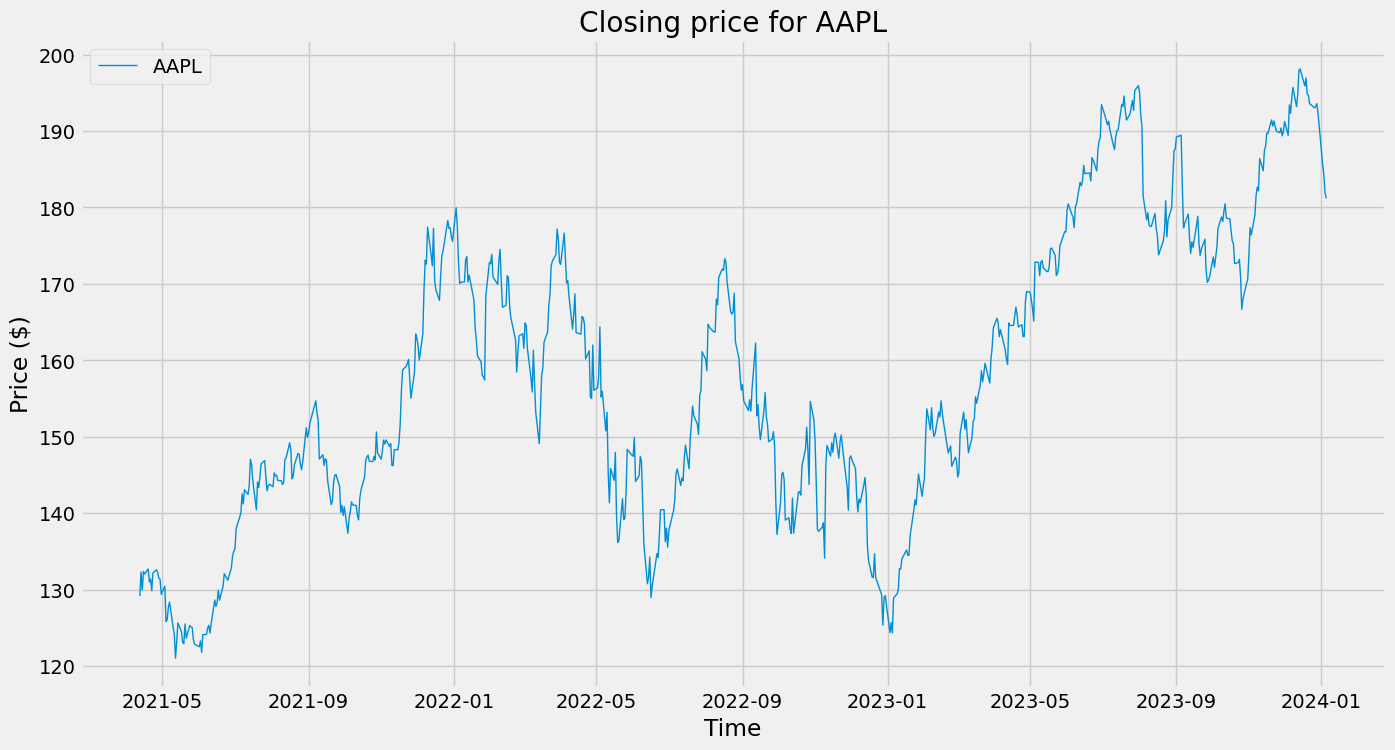

In [3]:
plt.figure(figsize=(15, 8))
plt.plot(df.Close, linewidth=1, label=stock)
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.title(f'Closing price for {stock}')
plt.legend()
plt.show()

In [4]:
data = pd.DataFrame()
data['Close'] = df.Close
data['20 SMA'] = df.Close.rolling(20).mean()
data['50 SMA'] = df.Close.rolling(50).mean()
data['100 SMA'] = df.Close.rolling(100).mean()
data['Funds'] = 100000

In [5]:
def signals(data):
    buy_price = []
    sell_price = []
    open_position = []
    funds = [100000] * len(data)
    last_funds = 100000
    flag = 0

    for i in range(len(data)):
        if data['20 SMA'][i] > data['50 SMA'][i]:
            if flag == 0:
                flag = 1
                buy_price.append(data['Close'][i])
                last_pos = last_funds/data['Close'][i]
                funds[i] = last_funds
                open_position.append(last_pos)
                sell_price.append(np.nan)
            else:
                buy_price.append(np.nan)
                last_funds = data['Close'][i] * last_pos
                funds[i] = last_funds
                open_position.append(last_pos)
                sell_price.append(np.nan)
        elif data['20 SMA'][i] < data['50 SMA'][i]:
            if flag == 1:
                flag = 0
                buy_price.append(np.nan)
                last_funds = last_pos * data['Close'][i]
                funds[i] = last_funds
                open_position.append(0)
                sell_price.append(data['Close'][i])
            else:
                buy_price.append(np.nan)
                funds[i] = last_funds
                open_position.append(0)
                sell_price.append(np.nan)
        else:
            buy_price.append(np.nan)
            open_position.append(0)
            sell_price.append(np.nan)

    return buy_price, sell_price, open_position, funds, flag

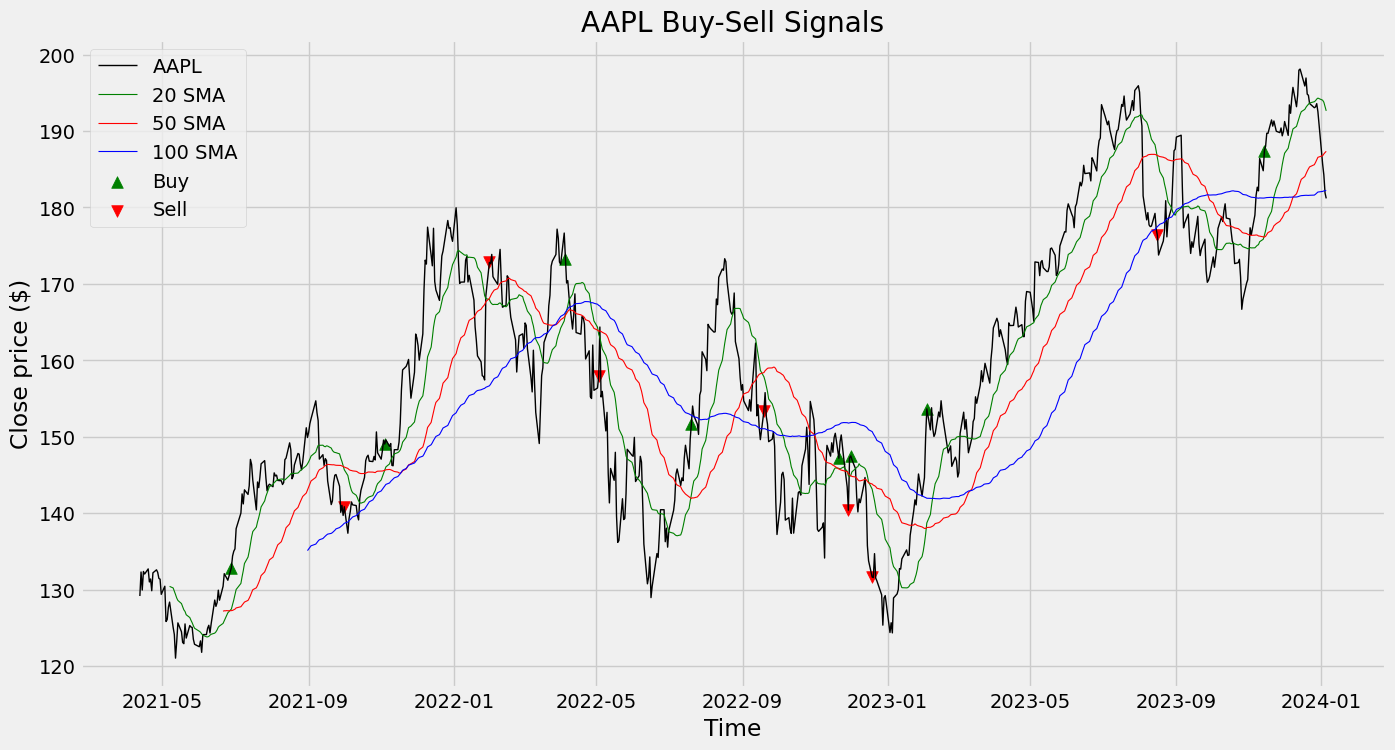

In [6]:
buy_sell = signals(data)
data['Buy price'] = buy_sell[0]
data['Sell price'] = buy_sell[1]
data['Open position'] = buy_sell[2]
data['Live position'] = data['Close'].multiply(data['Open position'])
data['Funds'] = buy_sell[3]

plt.figure(figsize = (15, 8))
plt.plot(data['Close'], label=stock, linewidth=1, color='black')
plt.plot(data['20 SMA'], label='20 SMA', linewidth=0.8, color='green')
plt.plot(data['50 SMA'], label='50 SMA', linewidth=0.8, color='red')
plt.plot(data['100 SMA'], label='100 SMA', linewidth=0.8, color='blue')
plt.scatter(data.index, data['Buy price'], label='Buy', marker='^', color='green', s=70)
plt.scatter(data.index, data['Sell price'], label='Sell', marker='v', color='red', s=70)
plt.title(f'{stock} Buy-Sell Signals')
plt.xlabel('Time')
plt.ylabel('Close price ($)')
plt.legend()
plt.show()

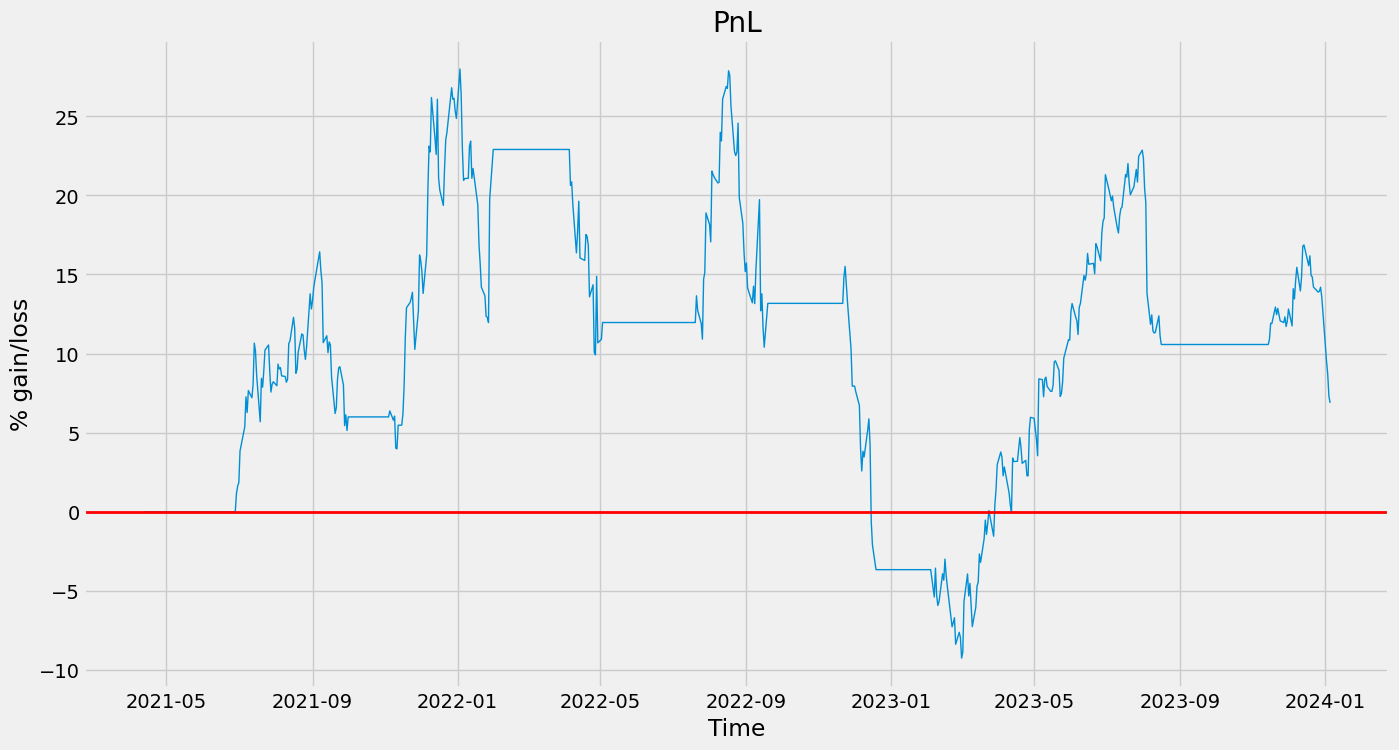

In [13]:
plt.figure(figsize = (15, 8))
plt.plot((data['Funds']/data['Funds'][0] - 1)*100, linewidth = 1.0)
plt.axhline(y=0, color='red', linewidth=2.0)
plt.title('PnL')
plt.ylabel('% gain/loss')
plt.xlabel('Time')
plt.show()